In [1]:
!pip install face_recognition

In [2]:
#!pip install tensorflow_federated

In [10]:
!pip install PyMuPDF

In [5]:
!wget https://www.dropbox.com/scl/fi/cifuml81vadix2u0pwfne/new_archive.zip?rlkey=0xur4c4lutjushrxv01jek9pi&dl=0 -O new_archive.zip

/bin/bash: line 1: -O: command not found
--2023-11-10 17:49:07--  https://www.dropbox.com/scl/fi/cifuml81vadix2u0pwfne/new_archive.zip?rlkey=0xur4c4lutjushrxv01jek9pi
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4e95f401cb1ff7e7796e19a349.dl.dropboxusercontent.com/cd/0/inline/CHRpZXVyahAWOvYUntx65pFjqT9ra1697njUdizTUwrkBDrHK0LaV-gZOcuwGPEqlEsjpkmpoG0vBwPZaBC31aKKFSF3IRy-G2AT6dDpqBEwEgCRlsYxJaTRXLMf3FqPvOvqXfzHtNS21PS2yiuFSnU-/file# [following]
--2023-11-10 17:49:09--  https://uc4e95f401cb1ff7e7796e19a349.dl.dropboxusercontent.com/cd/0/inline/CHRpZXVyahAWOvYUntx65pFjqT9ra1697njUdizTUwrkBDrHK0LaV-gZOcuwGPEqlEsjpkmpoG0vBwPZaBC31aKKFSF3IRy-G2AT6dDpqBEwEgCRlsYxJaTRXLMf3FqPvOvqXfzHtNS21PS2yiuFSnU-/file
Resolving uc4e95f401cb1ff7e7796e19a349.dl.dropboxusercontent.com (uc4e95f401cb1ff7e7796e19a349.dl.dro

In [6]:
!unzip -q new_archive.zip


In [12]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow.keras import applications
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm
from skimage import io
import glob
from PIL import Image, ImageEnhance, ImageChops, ImageStat, ImageDraw #8.4.0
import face_recognition
import fitz #1.21.1
from pathlib import Path
import shutil
import openpyxl
from itertools import chain

In [4]:
path ="/Data/Passaport" #(здесь Ваш путь до pdf-сканов документов)
gPDF=glob.glob('path/*.pdf')

In order to get a face image from a passport photo, pdf scans must be converted to an image format, for this the following function was written

In [ ]:
def extract_images_from_pdf(pdf):
    count = 0
    for tpdf in pdf:
        name = Path(tpdf).stem
        doc=fitz.open(tpdf)
        for i in range(len(doc)):
            for img in doc.get_page_images(i):
                xref=img[0]
                pix = fitz.Pixmap(doc,xref)
                if pix.n < 5:
                    pix.save(f'image_from_pdf/{name}p%s-%s.png' % (i,xref))
                else:
                    pix1 = fitz.Pixmap(fitz.csRGB, pix)
                    pix1.save(f'image_from_pdf/{name}p%s-%s.png' % (i,xref))
                    pix1 = None
                pix = None
                count+=1
    return f'Found {count} images'


#extract_images_from_pdf(gPDF)

Next, we get the path to all processed images from pdf scans and use the "face_recog_pdf" function to cut out the area where the face is in the photo. We save the result in a separate folder.

In [33]:
#g=glob.glob('image_from_pdf/*.png')
g=glob.glob(f'Data/Images/*.jpg')

def face_recog_pdf(gimage):
    count = 0
    for timage in gimage:
        name = Path(timage).stem
        img = face_recognition.load_image_file(timage)
        test_loc = face_recognition.face_locations(img)
        for f in test_loc:
            top, right,bottom, left = f
            face_img = img[top:bottom,left:right]
            pil_img = Image.fromarray(face_img)
            pil_img.save(f'pdf_img/{name}_face_{count}.jpg')
            count+=1
    return f'Found {count} face(s) in this photos'

# Применение функции
face_recog_pdf(g)

'Found 659 face(s) in this photos'

After processing pdf scans, we bring all the images to the same format and convert them into vectors (this method is used for the approach using convolutional autoencoders), for this we use the function:

In [34]:
filelist=glob.glob(f'pdf_img/*.jpg')
def image2array(filelist):
    image_array = []
    for image in filelist[:200]:
        img = io.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(img)
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3)
    image_array = image_array.astype('float32')
    image_array /= 255
    return np.array(image_array)

train_data = image2array(filelist)
print("Length of training dataset:", train_data.shape)

Length of training dataset: (200, 224, 224, 3)


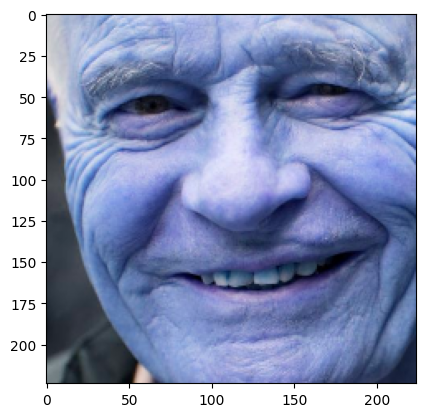

In [38]:
plt.imshow(train_data[159])

The next step is to convert them into vectors (for the approach using convolutional autoencoders, the function is specified above – image2array), later we will use vectors to compare and obtain sets of similar images.

The autoencoder itself is built by combining convolutional layers and pooling layers, which reduce the dimension of the image (collapse it) and extract the most important features. The output returns encoder and decoder. For the task of encoding an image into a vector, we need a layer after the autoencoder, i.e. a vector representation of the image, which will later be used to search for similar images.

Applying the summary() function to the model will show a description of how the model works layer by layer. You need to make sure that the size of the image at the input corresponds to the size of the image at the output of the decoder.

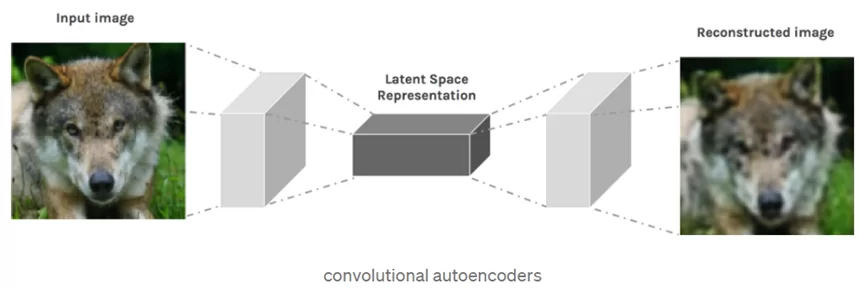

In [43]:
x=train_data[159]
IMG_SHAPE = x.shape[0:]
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(14*14*256))
    decoder.add(L.Reshape((14, 14, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder


encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [44]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')
autoencoder.fit(x=train_data, y=train_data, epochs=10, verbose=1)

Epoch 1/10
7/7 [==============================] - 21s 234ms/step - loss: 0.2728
Epoch 2/10
7/7 [==============================] - 1s 89ms/step - loss: 0.1241
Epoch 3/10
7/7 [==============================] - 1s 91ms/step - loss: 0.0774
Epoch 4/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0603
Epoch 5/10
7/7 [==============================] - 1s 88ms/step - loss: 0.0535
Epoch 6/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0495
Epoch 7/10
7/7 [==============================] - 1s 92ms/step - loss: 0.0437
Epoch 8/10
7/7 [==============================] - 1s 91ms/step - loss: 0.0421
Epoch 9/10
7/7 [==============================] - 1s 88ms/step - loss: 0.0409
Epoch 10/10
7/7 [==============================] - 1s 85ms/step - loss: 0.0396


Building an image similarity model using K-Nearest Neighbors
After obtaining a representation of the compressed data of all images, we can apply the K-nearest neighbor algorithm to search for similar images. It is based on the calculation of the Euclidean distance between vectors: the distances that will be the smallest will mean that the images are similar.

In [46]:
images = train_data
codes = encoder.predict(images)
assert len(codes) == len(images)

7/7 [==============================] - 0s 22ms/step


In [47]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In order to see which images the model considers similar, two functions were written that show 5 or more closest/similar photos to the one being compared.

In [52]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(image):
    distances,neighbors = get_similar(image,n_neighbors=3)
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")

    for i in range(3):
      plt.subplot(1,4,i+2)
      plt.imshow(neighbors[i])
      plt.title("Dist=%.3f"%distances[i])
    plt.show()

1/1 [==============================] - 0s 298ms/step


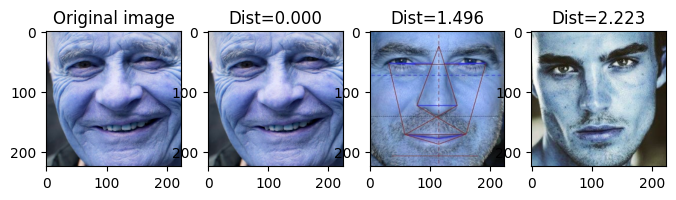

In [53]:
show_similar(images[159])

pre-trained models may get the wrong image size at the output, and when loading a dataset and converting images into a vector, there may not be enough memory and computer power, and it will also take a lot of time. Therefore, if you use pre-trained models, then you need to use the PCA dimension reduction method. At the same time, the autoencoder lowers the dimension and it can be configured so that the output is a vector of the required size.

The advantages of using pre-trained models is that there is no need to build a neural network, configure convolutional layers, you just need to take the right layer and use it for your own purposes. Also, such models have been trained on large datasets and have ready-made weights (settings) to extract the necessary features, they better highlight important areas in the image.

In order to use pre-trained models, first you need to download them. As an example, we take the VGG16 model – a convolutional network with 13 layers, which was trained on datasets with a large amount of input data (14 million images belonging to 1000 classes).

In [54]:
model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [55]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

(1, 224, 224, 3)

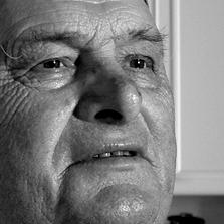

In [74]:
img,x=load_image("pdf_img/1001_face_148.jpg")
display(x.shape)
img

The VG 16 model is used to classify images, i.e. the class to which the image belongs (airplane, helicopter, etc.), so the output model uses a layer for classification. All the previous layers encode the image into a vector. This model can be completely copied with the removal of the last layer, so we get a model that only encodes the image in vector.

In [61]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

After the model is built, we apply it to our data. Then, we get the feature vector of each image and use the PCA dimension reduction method.

In [80]:
filelist=glob.glob(f'pdf_img/*.jpg')[:200]

In [82]:
import time
tic = time.perf_counter()
features = []
for i, image_paths in enumerate(filelist[:200]):
    if i % 500 == 0:
        toc = time.perf_counter()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.perf_counter()
    img, x = load_image(image_paths);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
print('finished extracting features for %d images' % len(images))

from sklearn.decomposition import PCA
features = np.array(features)
pca = PCA(n_components=100)
pca.fit(features)

pca_features = pca.transform(features)#import tensorflow_federated as tff


analyzing image 0 / 200. Time: 0.0002 seconds.
1/1 [==============================] - 0s 61ms/step
finished extracting features for 200 images


The following code shows how a vector from the dataset is randomly selected (the vector obtained at the previous stage), the distance from this vector to all vectors in the dataset is compared, these distances are sorted in ascending order and the closest/similar ones are selected.

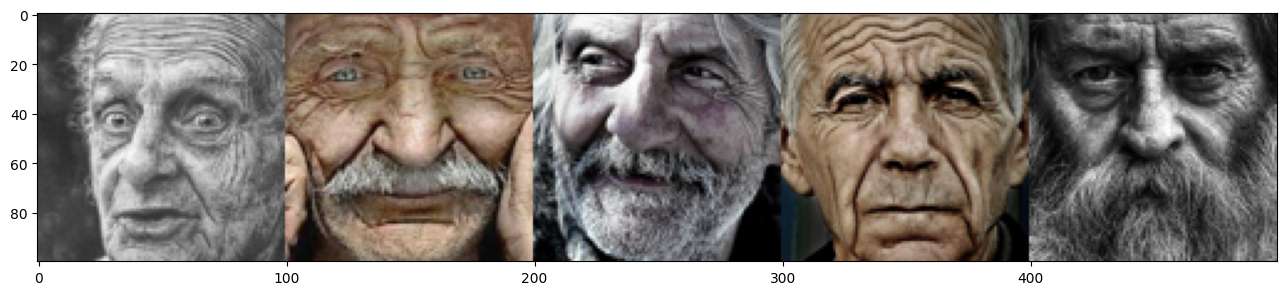

In [83]:
from scipy.spatial import distance
similar_idx = [ distance.cosine(pca_features[80], feat) for feat in pca_features ]

idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6] # отображение первых 6 похожих изображений

thumbs = []
for idx in idx_closest:
    img = image.load_img(filelist[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

Using ready-made libraries
The task (search for similar images) can also be solved with the help of ready-made libraries, one of these is the face_recognition library, based on the dlib library.

After we have received images with faces, we need to translate the images into a vector, for this there is a face_encodings () function in the face_recognition library, and the compare_faces function is used to compare vectors and, accordingly, similar images.

The library itself works the same way as neural networks, i.e. an image dataset was trained (173 MB in a gzip file), but unlike the previous method, the dataset consisted only of images of faces (the previous method used different images, including animals and transport).

In [92]:
from tqdm import tqdm
photo = glob.glob('pdf_img/*.jpg')

def get_vector(train_image):
    diff = {}
    bad = []
    for image in tqdm(train_image):
        try:
            img = face_recognition.load_image_file(image)
            img_enc = face_recognition.face_encodings(img)[0]
            diff.update({image:img_enc})
        except IndexError:
            bad.append(image)
    return diff, bad

r, bf = get_vector(photo)

100%|██████████| 658/658 [02:46<00:00,  3.95it/s]


In [95]:
len(r)

586

In [96]:
photo[9]

'pdf_img/1324_face_483.jpg'

In [102]:
r['pdf_img/1118_face_195.jpg']

array([-0.1256033 ,  0.09010787,  0.00525535, -0.09369688, -0.10644087,
        0.0818395 , -0.13212928, -0.09709886,  0.23289475, -0.10245594,
        0.17197116,  0.03288721, -0.21370991, -0.01615071, -0.04948194,
        0.07015545, -0.21735999, -0.17249188,  0.04518739, -0.09183495,
       -0.02606488,  0.03631075, -0.04278668,  0.07917987, -0.1642829 ,
       -0.29618379, -0.08688036, -0.12488641, -0.04506569, -0.0635279 ,
       -0.03538714,  0.04429551, -0.1776073 , -0.00405611, -0.01490444,
        0.13501723,  0.00604719, -0.00081219,  0.12949964,  0.00453252,
       -0.09784525, -0.04221877,  0.05789341,  0.22808421,  0.20120513,
       -0.01099391, -0.02681047, -0.05795091,  0.13743387, -0.24923669,
        0.08165591,  0.22395411,  0.01988858,  0.10770701,  0.07687587,
       -0.14146683, -0.03366876,  0.13620999, -0.09318213,  0.08355798,
       -0.0107558 , -0.03106525,  0.00922126, -0.05383832,  0.21020608,
        0.14717872, -0.08860879, -0.16090113,  0.13700067, -0.15

In [115]:
img1 = face_recognition.load_image_file(photo[9])
img1_enc = face_recognition.face_encodings(img1)[0]

IndexError: ignored

Original_image:
1324_face_483


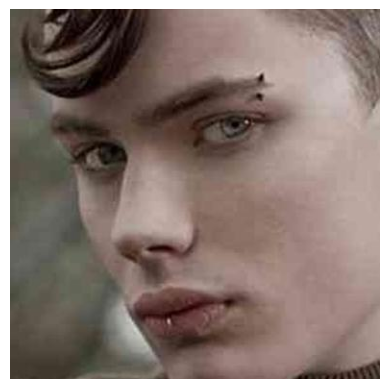

Compared images:


100%|██████████| 586/586 [00:00<00:00, 24392.75it/s]


1177_face_258
124_face_203
1145_face_68
1043_face_306
1303_face_74
2034_face_509
1147_face_568
11_face_655
2064_face_0
1258_face_488
1678_face_403
100_face_570
1461_face_48
359_face_42
182_face_49
1669_face_406
1590_face_553
1827_face_119
1052_face_489
700_face_265
483_face_494
1980_face_631
882_face_52
744_face_473
1003_face_546
1091_face_625
1484_face_559
1205_face_404
546_face_590
1835_face_580
1584_face_172
1718_face_340
1608_face_25
1532_face_318
1293_face_355
1964_face_127
1206_face_632
1674_face_26
1804_face_474
1474_face_578
1768_face_591
1180_face_143
1161_face_417
110_face_216
1630_face_401
1156_face_290
1306_face_41
1749_face_140
1298_face_76
2091_face_382
1528_face_201
1402_face_86
1733_face_236
1797_face_334
447_face_567
2066_face_206
41_face_182
1059_face_54
1398_face_61
2038_face_310
1021_face_170
1404_face_73
1879_face_501
1072_face_82
814_face_224
1923_face_506
477_face_521
1431_face_1
1452_face_470
1025_face_398
1084_face_638
1264_face_384
903_face_204
2071_face_237
1

In [120]:
def compare_faces(test_image, train_images):
    img1 = face_recognition.load_image_file(test_image)
    face_encodings = face_recognition.face_encodings(img1)

    img1_enc = face_encodings

    print('Original_image:')
    print(Path(test_image).stem)
    plt.imshow(img1)
    plt.axis('off')
    plt.show()

    print('Compared images:')
    differences = {}

    for name, vec in tqdm(train_images.items()):
        try:
            result = face_recognition.compare_faces([img1_enc], vec[0], tolerance=0.49)
            differences.update({name: result})
        except IndexError:
            pass

    new_df = {key: value for key, value in differences.items() if value == [True]}

    fig, axs = plt.subplots(1, len(new_df.keys()), figsize=(15, 5))

    for idx, i in enumerate(new_df.keys()):
        im = face_recognition.load_image_file(i)
        axs[idx].imshow(im)
        axs[idx].axis('off')
        print(Path(i).stem)

    plt.show()

compare_faces(photo[9], r)


Original_image:
1324_face_483


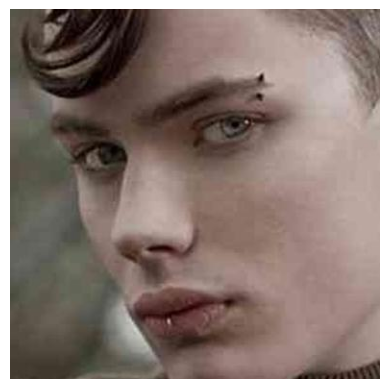

Compared images:


100%|██████████| 586/586 [00:00<00:00, 25366.24it/s]


1177_face_258
124_face_203
1145_face_68
1043_face_306
1303_face_74
2034_face_509
1147_face_568
11_face_655
2064_face_0
1258_face_488
1678_face_403
100_face_570
1461_face_48
359_face_42
182_face_49
1669_face_406
1590_face_553
1827_face_119
1052_face_489
700_face_265
483_face_494
1980_face_631
882_face_52
744_face_473
1003_face_546
1091_face_625
1484_face_559
1205_face_404
546_face_590
1835_face_580
1584_face_172
1718_face_340
1608_face_25
1532_face_318
1293_face_355
1964_face_127
1206_face_632
1674_face_26
1804_face_474
1474_face_578
1768_face_591
1180_face_143
1161_face_417
110_face_216
1630_face_401
1156_face_290
1306_face_41
1749_face_140
1298_face_76
2091_face_382
1528_face_201
1402_face_86
1733_face_236
1797_face_334
447_face_567
2066_face_206
41_face_182
1059_face_54
1398_face_61
2038_face_310
1021_face_170
1404_face_73
1879_face_501
1072_face_82
814_face_224
1923_face_506
477_face_521
1431_face_1
1452_face_470
1025_face_398
1084_face_638
1264_face_384
903_face_204
2071_face_237
1

In [124]:
def compare_faces(test_image, train_images):
    img1 = face_recognition.load_image_file(test_image)
    img1_enc = face_recognition.face_encodings(img1)
    print('Original_image:')
    print(Path(test_image).stem)
    plt.imshow(img1)
    plt.axis('off')
    plt.show()

    print('Compared images:')
    differences = {}


    for name, vec in tqdm(train_images.items()):
        try:
            result = face_recognition.compare_faces([img1_enc], vec[0], tolerance=0.49)
            differences.update({name: result})
        except IndexError:
            pass

    new_df = {key: value for key, value in differences.items() if value == [True]}

    fig, axs = plt.subplots(1, len(new_df.keys()), figsize=(15, 5))

    for idx, i in enumerate(new_df.keys()):
        im = face_recognition.load_image_file(i)
        axs[idx].imshow(im)
        axs[idx].axis('off')
        print(Path(i).stem)

    plt.show()

compare_faces(photo[9], r)


In [ ]:
# перевод изображения в вектор
def get_true_images(test_image, train_image):
    names = {}
    for t in tqdm(test_image):
        differences = {}
        try:
            img1 = face_recognition.load_image_file(t)
            img1_enc = face_recognition.face_encodings(img1)[0]
        except IndexError:
            print(t)
        for name, vector in train_image.items():
            try:
                result = face_recognition.compare_faces([img1_enc], vector, tolerance=0.4)
                differences.update({name:result})
            except IndexError:
                pass
        new_df = {key:value for key,value in differences.items() if value == [True]}
        names.update({t:list(new_df.keys())})
return names

# получение словаря со списком похожих фотографий
def get_names(dictionary):
    new_list = {}
    for idx, i in enumerate(list(dictionary.keys())):
        b = Path(i).stem
        stem = []
        for j in list(dictionary.values())[idx]:
            a = Path(j).stem
            stem.append(a)
        new_list.update({b:stem})
    data = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in new_list.items()]))
    return data

# Использование функции
d = get_names(dictionary)

# Сохранение функции в Excel-файл
d.to_excel('find_faces.xlsx', sheet_name = 'Test')

In [ ]:

#dataset=tff.simulation.datasets.celeba.load_data(
  #  split_by_clients=True, cache_dir=None
#)
# Access the train and test datasets
#train_dataset = dataset[0]  # The first element in the tuple is the train dataset
#test_dataset = dataset[1]   # The second element in the tuple is the test dataset

In [ ]:
#train_dataset

AttributeError: ignored